# Set Up

## Imports

In [1]:
import os
import math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2

import random
from PIL import Image

In [2]:
# !pip install CMake
!pip install dlib
!pip install face_recognition

In [3]:
import face_recognition

## Image example

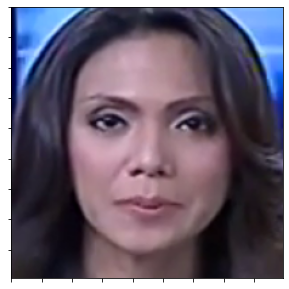

(224, 224, 3)


In [4]:
path = '0135.png'
test_img = cv2.imread(path)
test_img = np.array(test_img)
test_img = cv2.resize(test_img,(224,224))
test_img = cv2.cvtColor(test_img, cv2.COLOR_RGB2BGR) # not necessary (changes colour output)

# show
fig, ax = plt.subplots(figsize = (5, 5))
plt.imshow(test_img);
ax.set_xticklabels([])
ax.set_yticklabels([])
plt.show()
print(test_img.shape)

# GridMask

In [5]:
import cutout_augmentation as ca

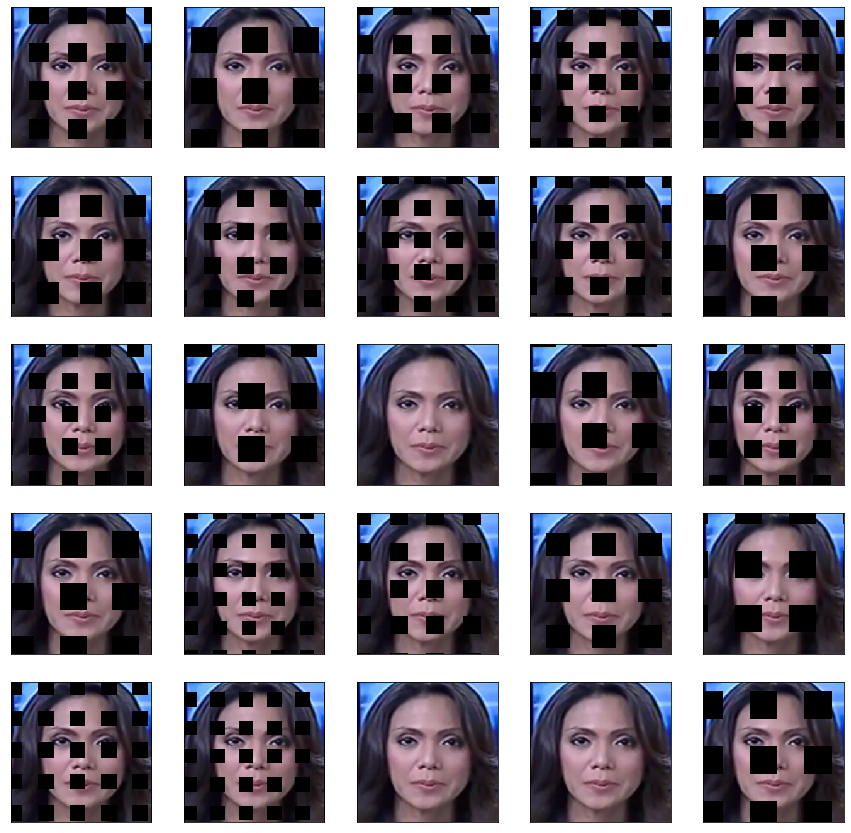

In [6]:
fig, axe = plt.subplots(5, 5, figsize=(15, 15))
for i in range(5):
    for j in range(5):
        axe[i][j].imshow(ca.GridMask_augmentation(test_img, 0.85), interpolation="nearest")
        axe[i][j].set_xticks([])
        axe[i][j].set_yticks([])

plt.show()

# GridMask-Alternative

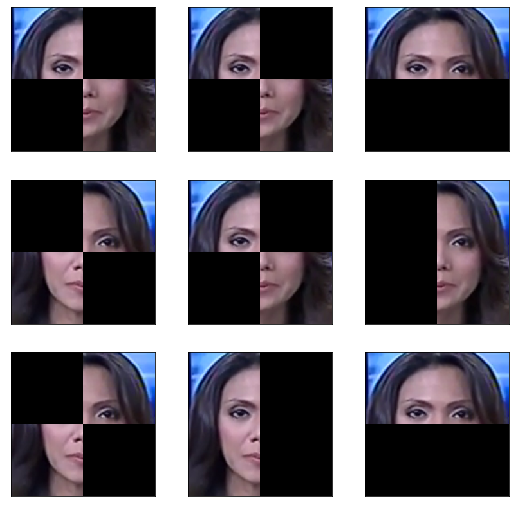

In [6]:
def display_images_alternative_GridMask(image, x, size):
    fig, axe = plt.subplots(x, x, figsize=(size, size))
    for i in range(x):
        for j in range(x):
            augmented = ca.alternative_GridMask_augmentation(image, 1.0)
            axe[i][j].imshow(augmented, interpolation="nearest")
            axe[i][j].set_xticks([])
            axe[i][j].set_yticks([])
    plt.show()

display_images_alternative_GridMask(test_img, 3, 9)

# FacialArtifacts Augmentation

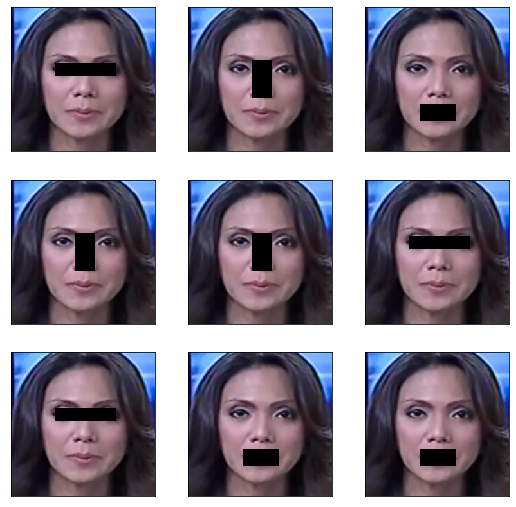

In [7]:
def display_images_facial_artifacts(image, x, size):
    fig, axe = plt.subplots(x, x, figsize=(size, size))
    for i in range(x):
        for j in range(x):
            augmented = ca.facial_artifacts_cutout_augmentation(image, 1.0)
            axe[i][j].imshow(augmented, interpolation="nearest")
            axe[i][j].set_xticks([])
            axe[i][j].set_yticks([])
    plt.show()

display_images_facial_artifacts(test_img, 3, 9)

# FaceMask Augmentation

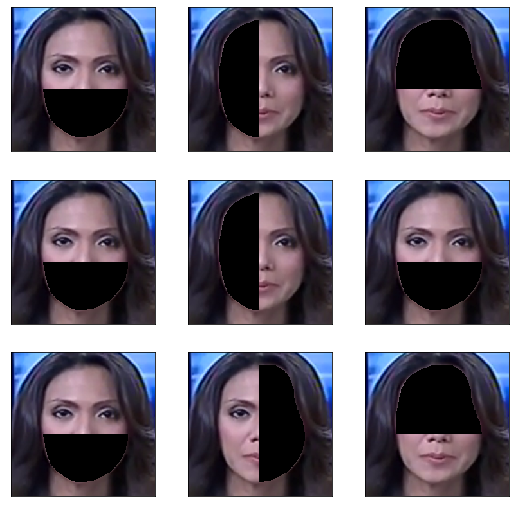

In [5]:
def display_images_facial_mask(image, x, size):
    fig, axe = plt.subplots(x, x, figsize=(size, size))
    for i in range(x):
        for j in range(x):
            augmented = ca.facial_mask_cutout_augmentation(image, 1.0)
            axe[i][j].imshow(augmented, interpolation="nearest")
            axe[i][j].set_xticks([])
            axe[i][j].set_yticks([])
    plt.show()

display_images_facial_mask(test_img, 3, 9)

# Facial-Artifacts-Alternative Augmentation

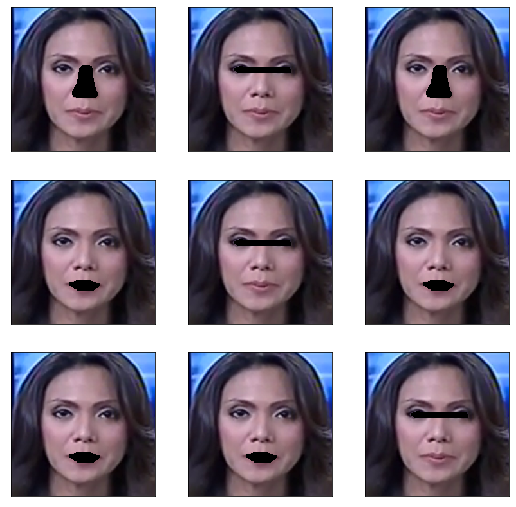

In [7]:
def display_images_alternative_facial_artifacts(image, x, size):
    fig, axe = plt.subplots(x, x, figsize=(size, size))
    for i in range(x):
        for j in range(x):
            augmented = ca.alternative_facial_artifacts_cutout_augmentation(image, 1.0)
            axe[i][j].imshow(augmented, interpolation="nearest")
            axe[i][j].set_xticks([])
            axe[i][j].set_yticks([])
    plt.show()

display_images_alternative_facial_artifacts(test_img, 3, 9)

# Models

In [7]:
# See available GPU RAM 
!nvidia-smi # can also be run from linux shell while GPU is training
# !nvidia-smi dmon # this will stream memory utilisation
# !htop # cpu threads and if they're all working

Tue Jul  7 11:47:44 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.87.01    Driver Version: 418.87.01    CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P0    29W /  70W |  14253MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [8]:
# This cell has the latest set up for AI Platform

from __future__ import print_function
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
import os
import glob
import cv2
from io import BytesIO
from PIL import Image
from numpy import expand_dims
import tensorflow.keras
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import *
import warnings
import logging
from IPython.display import clear_output
from collections import Counter
import pickle
import sys
sys.path.insert(1, '/home/jupyter/DeepFake-2019-20/visualisations')
import VisualisationTools as plotting

warnings.filterwarnings("ignore")
logger = logging.getLogger()
logger.setLevel(100)
plot_losses = plotting.PlotLearning()
os.chdir('/home/jupyter/DeepFake-2019-20')


print("Tensorflow version:", tf.__version__)

Tensorflow version: 2.2.0-dlenv


In [14]:
# Required for EfficientNet
!pip install git+https://github.com/qubvel/efficientnet

  Cloning https://github.com/qubvel/efficientnet to /tmp/pip-req-build-f2l4vmmr
  Running command git clone -q https://github.com/qubvel/efficientnet /tmp/pip-req-build-f2l4vmmr
  Created wheel for efficientnet: filename=efficientnet-1.1.0-py3-none-any.whl size=18326 sha256=e36cfd1efc4687731028b4e3cb62e267cf21157b43f0a3d94e2c3bf772d36e70
  Stored in directory: /tmp/pip-ephem-wheel-cache-js8jmhdy/wheels/11/69/85/814d64d694c96db0eef17b718042d644a1e54f113920481920
Successfully built efficientnet


## Build Model

In [15]:
def build_model(dropout, lr_rate, architecture):
    '''Builds a specified network with the selected dropout after the last dense layer.

    Architectures that can be selected are:
    vgg, xception, resnet50, mobilenet, efficientnet, densenet
    
    Optimiser is Adam, with a provided learning rate (lr_rate) and fixed
    decay 1e-6, loss is traditionally categorical_crossentropy.'''

    from tensorflow.keras.preprocessing import image
    from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

    if architecture=='xception':
        from tensorflow.keras.applications.xception import Xception
        conv_base = Xception(weights='imagenet', include_top=False,
                        input_shape=(224,224,3))

    elif architecture=='vgg':
        from tensorflow.keras.applications.vgg16 import VGG16
        conv_base = VGG16(weights='imagenet', include_top=False,
                        input_shape=(224,224,3))
      
    elif architecture=='resnet50':
        from tensorflow.keras.applications.resnet50 import ResNet50
        conv_base = ResNet50(weights='imagenet', include_top=False,
                        input_shape=(224,224,3))
      
    elif architecture=='mobilenet':
        from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
        conv_base = MobileNetV2(weights='imagenet', include_top=False,
                        input_shape=(224,224,3))

    elif architecture== 'efficientnet':
        # EfficientNetB7 has the highest top-1 accuracy on imagenet
        # among EfficientNextB{0:7}
        from efficientnet.tfkeras import EfficientNetB0
        conv_base = EfficientNetB0(weights='noisy-student', include_top=False,
                        input_shape=(224,224,3))
        
    elif architecture== 'densenet':
        from tensorflow.keras.applications.densenet import DenseNet201
        conv_base = DenseNet201(weights='imagenet', include_top=False,
                        input_shape=(224,224,3))

    elif architecture not in ['vgg', 'xception', 'resnet50',
                              'mobilenet', 'efficientnet', 'densenet']:
        return "An unknown network is specified"
    

    outputconv_base = conv_base.output
    t_flat = Flatten()(outputconv_base)
    t_dense1 = Dense(1024, activation='relu')(t_flat)
    t_dense2 = Dense(256, activation='relu')(t_dense1)
    t_dense3 = Dense(128, activation='relu')(t_dense2)
    t_do = Dropout(dropout)(t_dense3)
    predictions = Dense(2, activation= 'softmax')(t_do)

    model = Model(inputs=conv_base.input, outputs=predictions, name = 'model')

    conv_base.trainable = False # freeze the convolutional base
    
    # # Code below trains all layers without using any pretrained weights
    #for layer in conv_base.layers:
    #  layer.trainable = True

#     opt = tf.keras.optimizers.Adam(learning_rate= lr_rate, decay=1e-6)
    opt = tf.keras.optimizers.Adam(learning_rate=lr_rate)

    model.compile(loss='binary_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])
    return model

## Augment Data

In [16]:
def augment_data(directory, batch, cutout_augmentation = None):
    '''Prepares train-time augmentation using given training and validations data)
    
    Returns train_data, val_data'''

    datagen = ImageDataGenerator(
            featurewise_center=False,  # set input mean to 0 over the dataset
            samplewise_center=True,  # set each sample mean to 0
            featurewise_std_normalization=False,  # divide inputs by std of the dataset
            samplewise_std_normalization=True,  # divide each input by its std
            zca_whitening=False,  # apply ZCA whitening
            zca_epsilon=1e-06,  # epsilon for ZCA whitening
            rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
            # randomly shift images horizontally (fraction of total width)
            width_shift_range=0.1,
            # randomly shift images vertically (fraction of total height)
            height_shift_range=0.1,
            shear_range=0.,  # set range for random shear
            zoom_range=0.,  # set range for random zoom
            channel_shift_range=0.,  # set range for random channel shifts
            # set mode for filling points outside the input boundaries
            fill_mode='nearest',
            cval=0.,  # value used for fill_mode = "constant"
            horizontal_flip=True,  # randomly flip images
            vertical_flip=False,  # randomly flip images
            # set rescaling factor (applied before any other transformation)
            rescale=None,
            # set function that will be applied on each input
            preprocessing_function=cutout_augmentation,
            # image data format, either "channels_first" or "channels_last"
            data_format=None,
            # fraction of images reserved for validation (strictly between 0 and 1)
            )

    # Classes give the folders storing the two different categories
    train_data = datagen.flow_from_directory(directory + '/train',
                                             target_size=(224,224), batch_size = batch)
    
    val_data = datagen.flow_from_directory(directory + '/validation',
                                             target_size=(224,224), batch_size = batch)
    
    return train_data, val_data

## Auxiliary Train-Time Functions

In [17]:
def calculate_class_weights(train_data):
    '''Calculates class weights that weight the data based on the imbalance.
    Allows for better analysis in the case of imbalanced data - has no effect
    if data is balanced since the weights are then equal for each class.
    Use the generator obtained from the flow_from_directory method to obtain
    the class_weights.
    
    Input:
    train_data: the generator obtained during augmentation
    
    Returns a dictionary with class weights, required format for training'''
    
    # Calculate class weights which are required to fully balance the classes
    # Compares frequencies of appearence for each distinct label
    
    # The line of code below can be used on a generator to find the index labels
    print('Ensure class weights function corresponds to these class indices:',
          train_data.class_indices)
    
    counter = Counter(train_data.classes)                          
    max_val = float(max(counter.values()))       
    class_weights = {class_id : max_val/num_images for class_id, num_images in counter.items()}                     

    return class_weights

def load_model_weights(model, architecture, cutout = 'no_cutout_'):
    '''An alternative to training if there are already some generated weights
    
    Takes a built model (and its architecture type) and loads the weights
    with the highest validation accuracy.
    
    If there are no saved weights, a message is printed. '''

    path_to_weights = "../all_faces_bucket/trained_models/weights/augmentations/" + cutout + architecture
    # get all the weights file names in a list
    if os.path.exists(path_to_weights):
        all_weights = sorted(os.listdir(path_to_weights + '/'))
    # if there is at least one file
        if len(all_weights) >= 1:
            # pick out accuracies out of file names
            acc = [el[len(el)-10 : len(el)-5] for el in all_weights]
            # get index of the first maximum accuracy
            optimal_index = acc.index(max(acc))
            # get the name of the file with optimal weights, load corresponding weights
            optimal_weights = all_weights[optimal_index]
            print("Loading", path_to_weights + '/' + optimal_weights)
            model.load_weights(path_to_weights + '/' + optimal_weights)
            
        else: # otherwise warn that no weights were loaded
            print("There are no weights stored. Training model from scratch:")   
    
    else: # otherwise warn that no weights were loaded
        print("There are no weights stored. Training model from scratch:")   
        
def save_model_from_best_weights(dropout, lr_rate, architecture, cutout = 'no_cutout_'):
    '''Takes the latest saved weights and saves the corresponding model.'''
    model = build_model(dropout, lr_rate, architecture)
    load_model_weights(model, architecture, cutout)
    model.save('../all_faces_bucket/trained_models/saved_models/augmentations/' + cutout + architecture + '_model.h5')

## Training Functions

In [18]:
def train_model(model, train_data, val_data, epochs, class_weights, architecture, cutout = 'no_cutout_'):
    '''Trains a provided model.
    Takes 6 arguments:
    
    1. model: a built model with an architecture specified in the build function
    2. train_data: augmented data obtained from the augment_data function
    3. val_data: validation data obtained from the augment_data function
    4. epochs -- number of epochs
    5. class weights -- a dictionary with weights (equal for balanced data so
    no negative impact)
    6. architecture: can choose vgg, xception, resnet50, mobilenet or efficientnet
    '''
    
    # Make a trained_models folder if it doesn't exist
    if not os.path.exists('../all_faces_bucket/trained_models'):
        os.makedirs('../all_faces_bucket/trained_models')
    
    # Make a weights folder if it doesn't exist
    if not os.path.exists('../all_faces_bucket/trained_models/weights'):
        os.makedirs('../all_faces_bucket/trained_models/weights')
        
    # Make a weights folder for the architecture if it doesn't exist
    if not os.path.exists('../all_faces_bucket/trained_models/weights/augmentations/' + cutout + architecture):
        os.makedirs('../all_faces_bucket/trained_models/weights/augmentations/' + cutout + architecture)

    # Save weights - below saves every epoch where there is improvement
    # filepath="../all_faces_bucket/trained_models/weights/" + architecture + "/epochs:{epoch:03d}-val_acc:{val_accuracy:.3f}.hdf5"
    # Below saves on file - the weights with the highest validation accuracy
    filepath="../all_faces_bucket/trained_models/weights/augmentations" + cutout + architecture + "/highest_val_acc.hdf5"
    checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', 
                                verbose=1, save_best_only=True, mode='max')
    
    # Make a folder to store training accuracies if it doesn't exist
    if not os.path.exists('../all_faces_bucket/trained_models/training_accuracies/augmentations'):
        os.makedirs('../all_faces_bucket/trained_models/training_accuracies/augmentations')
    
    # Callback to save training accuracies after each epoch
    csv_logger = CSVLogger('../all_faces_bucket/trained_models/training_accuracies/augmentations/' + cutout + architecture + ".csv",
                           separator=',', append=True)
    
    # Stop after 3 epochs if val_accuracy doesn't improve
    es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=7)
                          
    # Load previous weights from training if there are any
    load_model_weights(model, architecture, cutout)

    history = model.fit(train_data, epochs=epochs, shuffle=True,
              steps_per_epoch = train_data.n//train_data.batch_size,
              validation_data = val_data, 
              validation_steps = val_data.n//val_data.batch_size,
              class_weight=class_weights,
              callbacks=[plot_losses, checkpoint, csv_logger, es],
              verbose=1,
              max_queue_size=30,                # maximum size for the generator queue
              workers=16,                        # maximum number of processes to spin up when using process-based threading
              use_multiprocessing=False)
    
    # Make a saved models folder if it doesn't exist
    if not os.path.exists('../all_faces_bucket/trained_models/saved_models'):
        os.makedirs('../all_faces_bucket/trained_models/saved_models')
    
    # Make an augmentations saved models folder if it doesn't exist
    if not os.path.exists('../all_faces_bucket/trained_models/saved_models/augmentations'):
        os.makedirs('../all_faces_bucket/trained_models/saved_models/augmentations')

## Unifying Function

In [19]:
def run_training(dropout = 0.5, lr_rate = 0.0001, architecture = 'vgg', 
                 batch = 32, epochs = 50, cutout_augmentation = None, cutout = 'no_cutout_'):

    '''Builds a model based on the specified architecture, augments training
    data (reserving a fraction for validation), then computes class weights to
    balance data and trains the model.
    
    Inputs:
    1. dropout  -- for the model
    2. lr_rate
    3. architecture -- a choice of vgg, resnet50, mobilenet, xception and efficientnet
    4. batch -- batch size
    5. epochs -- number of epochs
    '''

    # Build a model, augment data, get class_weights and train the model
    # Strategy scope allows us to leverage multiple GPUs
    strategy = tf.distribute.MirroredStrategy()
    print('Number of devices: {}'.format(strategy.num_replicas_in_sync))
    
    with strategy.scope(): # Everything that creates variables should be under the strategy scope.
        model = build_model(dropout, lr_rate, architecture)
    train_data, val_data = augment_data('../all_faces_disk/home/jupyter/forensics_split', batch, cutout_augmentation)
    class_weights = calculate_class_weights(train_data)
    trained_model = train_model(model, train_data, val_data, epochs, class_weights, architecture, cutout)

## Train Various Model Architectures
Note: Make sure CPUs have enough memory for each batch eg. 1 core with 3.75GB RAM cant take batches larger than 32.
8 CPUs with 30GB RAM typically works well for batches of 256.
Also note that while multiprocessing speeds up training, it interacts badly with Tensorflow and leads to deadlocks. To be on the safe side, set use_multiprocessing to false when training.

### MobileNet

#### GridMask

In [ ]:
run_training(dropout = 0.5, lr_rate = 0.0002, architecture = 'mobilenet', batch = 256, epochs = 1,
             cutout_augmentation = ca.GridMask_augmentation, cutout = 'GridMask_')
save_model_from_best_weights(dropout = 0.5, lr_rate = 0.0002, architecture = 'mobilenet', cutout = 'GridMask_')

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of devices: 1
Found 113928 images belonging to 2 classes.
Found 21291 images belonging to 2 classes.
Ensure class weights function corresponds to these class indices: {'authentic': 0, 'fake': 1}
There are no weights stored. Training model from scratch:
394/445 [=========================>....] - ETA: 3:56 - accuracy: 0.5807 - loss: 1.1327

#### GridMask-Alternative

In [ ]:
run_training(dropout = 0.5, lr_rate = 0.0002, architecture = 'mobilenet', batch = 256, epochs = 100,
             ca.alternative_GridMask_augmentation)
save_model_from_best_weights(dropout = 0.5, lr_rate = 0.0002, architecture = 'mobilenet')

#### FacialArtifacts

In [ ]:
run_training(dropout = 0.5, lr_rate = 0.0002, architecture = 'mobilenet', batch = 256, epochs = 100,
            ca.facial_artifacts_cutout_augmentation)
save_model_from_best_weights(dropout = 0.5, lr_rate = 0.0002, architecture = 'mobilenet')

#### FacialArtifacts-Alternative

In [ ]:
run_training(dropout = 0.5, lr_rate = 0.0002, architecture = 'mobilenet', batch = 256, epochs = 100,
            ca.alternative_facial_artifacts_cutout_augmentation)
save_model_from_best_weights(dropout = 0.5, lr_rate = 0.0002, architecture = 'mobilenet')

#### FaceMask

In [ ]:
run_training(dropout = 0.5, lr_rate = 0.0002, architecture = 'mobilenet', batch = 256, epochs = 100,
            ca.facial_mask_cutout_augmentation)
save_model_from_best_weights(dropout = 0.5, lr_rate = 0.0002, architecture = 'mobilenet')

### EfficientNet

### DenseNet